<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor Imagery Task Classification


#Extracting Data

##Downloading BCI Competition IV 2a Dataset

In [1]:
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip

--2024-10-22 16:53:00--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
Resolving www.bbci.de (www.bbci.de)... 130.149.80.149
Connecting to www.bbci.de (www.bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439968864 (420M) [application/zip]
Saving to: ‘BCICIV_2a_gdf.zip’

BCICIV_2a_gdf.zip   100%[===================>] 419.59M  11.3MB/s    in 40s     

2024-10-22 16:53:41 (10.6 MB/s) - ‘BCICIV_2a_gdf.zip’ saved [439968864/439968864]



In [2]:
!mkdir -p /content/cleaned_data/

In [3]:
%%capture
!unzip /content/BCICIV_2a_gdf.zip -d raw_data

#Installing Packages

In [4]:
%%capture
!pip install mne

In [5]:
%%capture
!pip install torch-summary

#Libraries Used

In [6]:
import os
import mne
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Building Dataset

In [7]:
!mkdir -p /content/cleaned_data/first_session
!mkdir -p /content/cleaned_data/second_session

##First Session

In [8]:
raw_data_folder = '/content/raw_data/'
cleaned_data_folder = '/content/cleaned_data/first_session/'
files = os.listdir(raw_data_folder)

# Selecting files with suffix 'T.gdf'
filtered_files = [file for file in files if file.endswith('T.gdf')]

raw_list = []

# Iterating through filtered files
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file)

    # Reading raw data
    raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
    # Droping EOG channels
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

    # High Pass Filtering 4-40 Hz
    raw.filter(l_freq=4, h_freq=40, method='iir')

    # Notch filter for Removal of Line Voltage
    raw.notch_filter(freqs=50)

    # Saving the modified raw data to a file with .fif suffix
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)
    # Appending data to the list
    raw_list.append(raw)

final_raw = mne.concatenate_raws(raw_list)
new_file_path = os.path.join(cleaned_data_folder, 'First_Session_Subjects.fif')
final_raw.save(new_file_path, overwrite=True)


Extracting EDF parameters from /content/raw_data/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 678979  =      0.000 ...  2715.916 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A06T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A06T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A06T.fif
[done]
Extracting EDF parameters from /content/raw_data/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A09T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A09T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A09T.fif
[done]
Extracting EDF parameters from /content/raw_data/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Writing /content/cleaned_data/first_session/A05T.fif


<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A05T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A05T.fif
[done]
Extracting EDF parameters from /content/raw_data/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A03T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A03T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A03T.fif
[done]
Extracting EDF parameters from /content/raw_data/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A08T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A08T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A08T.fif
[done]
Extracting EDF parameters from /content/raw_data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A01T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A01T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A01T.fif
[done]
Extracting EDF parameters from /content/raw_data/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A04T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A04T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A04T.fif
[done]
Extracting EDF parameters from /content/raw_data/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Writing /content/cleaned_data/first_session/A02T.fif


<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A02T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A02T.fif
[done]
Extracting EDF parameters from /content/raw_data/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/A07T.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
<ipython-input-8-52d09285b9e3>:27: RuntimeWarning: This filename (/content/cleaned_data/first_session/A07T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/A07T.fif
[done]
Writing /content/cleaned_data/first_session/First_Session_Subjects.fif


<ipython-input-8-52d09285b9e3>:33: RuntimeWarning: This filename (/content/cleaned_data/first_session/First_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/First_Session_Subjects.fif
[done]


**List of the events**  
'1023': 1 Rejected trial  
'1072': 2 Eye movements  
'276': 3 Idling EEG (eyes open)  
'277': 4 Idling EEG (eyes closed)  
'32766': 5 Start of a new run  
'768': 6 Start of a trial  
'769': 7 Cue onset **Left** (class 1) : 0  
'770': 8 Cue onset **Right** (class 2) : 1  
'771': 9 Cue onset **Foot** (class 3) : 2  
'772': 10 Cue onset **Tongue** (class 4): 3

In [9]:
events = mne.events_from_annotations(final_raw)
events[1]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

**Time choice:**  
[0.s, 4s] Post Cue on set:  [2s, 6s]

In [10]:
epochs = mne.Epochs(final_raw, events[0], event_id=[7, 8, 9, 10], tmin=0, tmax=4, reject=None, baseline=None, preload=True)
first_session_data = epochs.get_data(copy=True)
first_session_labels = epochs.events[:,-1]

Not setting metadata
2592 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2592 events and 1001 original time points ...
0 bad epochs dropped


In [11]:
print("First_session_dataset shape:",first_session_data.shape)

First_session_dataset shape: (2592, 22, 1001)


##Second Session

###Extracting Labels for datas with "E.gdf" prefix

In [12]:
# Replace this with your actual shareable link
shareable_link = 'https://drive.google.com/file/d/11Ke2Xta1kv2xu2Mybuu_X51zJYjQ-VFo/view?usp=drive_link'

# Extract file ID from the shareable link
file_id = shareable_link.split('/d/')[1].split('/view')[0]

# Create the direct download link
download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

# Specify the output file path
output_file = 'true_labels.zip'

# Download the file
gdown.download(download_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=11Ke2Xta1kv2xu2Mybuu_X51zJYjQ-VFo&export=download
To: /content/true_labels.zip
100%|██████████| 7.20k/7.20k [00:00<00:00, 8.68MB/s]


'true_labels.zip'

In [13]:
%%capture
!unzip /content/true_labels.zip -d second_session_labels

###Extracting datas of second session

In [14]:
raw_data_folder = '/content/raw_data/'
cleaned_data_folder = '/content/cleaned_data/second_session/'
mat_folder = '/content/second_session_labels/'

# Selecting files with suffix 'E.mat'
mat_files = os.listdir(mat_folder)
filtered_math_labels = [file for file in mat_files if file.endswith('E.mat')]

# Selecting files with suffix 'E.gdf'
files = os.listdir(raw_data_folder)
filtered_files = [file for file in files if file.endswith('E.gdf')]

raw_list = []
second_session_labels = np.array([])
# Iterating through filtered files
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file)

    # Reading raw data
    raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
    # Droping EOG channels
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

    # High Pass Filtering 4-40 Hz
    raw.filter(l_freq=4, h_freq=40, method='iir')

    # Saving the modified raw data to a file with .fif suffix
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)
    # Appending data to t he list
    raw_list.append(raw)

    # Mat files for the labels
    mat_file_name = file.replace('.gdf', '.mat')
    mat_file_path = os.path.join(mat_folder, mat_file_name)
    print(f"data:{file}, label:{mat_file_name}")

    if os.path.exists(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        class_labels = mat_data.get('classlabel', [])

        # Check if 'classlabel' key exists and is not empty
        if class_labels.size > 0:
             # Convert to a NumPy array and flatten
            class_labels_array = np.array(class_labels, dtype=int).flatten()
            # Concatenate with the existing test_labels array
            second_session_labels = np.concatenate((second_session_labels, class_labels_array))
        else:
            print(f"Warning: 'classlabel' not found or empty in {mat_file_name}.")
    else:
        print(f"Warning: {mat_file_name} not found.")

final_raw = mne.concatenate_raws(raw_list)
new_file_path = os.path.join(cleaned_data_folder, 'Second_Session_Subjects.fif')
final_raw.save(new_file_path, overwrite=True)

Extracting EDF parameters from /content/raw_data/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A01E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A01E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A01E.fif
[done]
data:A01E.gdf, label:A01E.mat
Extracting EDF parameters from /content/raw_data/A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A05E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A05E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A05E.fif
[done]
data:A05E.gdf, label:A05E.mat
Extracting EDF parameters from /content/raw_data/A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A08E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A08E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A08E.fif
[done]
data:A08E.gdf, label:A08E.mat
Extracting EDF parameters from /content/raw_data/A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A09E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A09E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A09E.fif
[done]
data:A09E.gdf, label:A09E.mat
Extracting EDF parameters from /content/raw_data/A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A03E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A03E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A03E.fif
[done]
data:A03E.gdf, label:A03E.mat
Extracting EDF parameters from /content/raw_data/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A07E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A07E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A07E.fif
[done]
data:A07E.gdf, label:A07E.mat
Extracting EDF parameters from /content/raw_data/A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A02E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A02E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A02E.fif
[done]
data:A02E.gdf, label:A02E.mat
Extracting EDF parameters from /content/raw_data/A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A06E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A06E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A06E.fif
[done]
data:A06E.gdf, label:A06E.mat
Extracting EDF parameters from /content/raw_data/A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/second_session/A04E.fif


<ipython-input-14-17b2bcb1c589>:29: RuntimeWarning: This filename (/content/cleaned_data/second_session/A04E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/A04E.fif
[done]
data:A04E.gdf, label:A04E.mat
Writing /content/cleaned_data/second_session/Second_Session_Subjects.fif


<ipython-input-14-17b2bcb1c589>:55: RuntimeWarning: This filename (/content/cleaned_data/second_session/Second_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/second_session/Second_Session_Subjects.fif
[done]


**List of the events**  
'1023': 1 Rejected trial  
'1072': 2 Eye movements  
'276': 3 Idling EEG (eyes open)  
'277': 4 Idling EEG (eyes closed)  
'32766': 5 Start of a new run  
'768': 6 Start of a trial  
'783': 7 Cue unknown

In [15]:
events = mne.events_from_annotations(final_raw)
events[1]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}

In [16]:
epochs = mne.Epochs(final_raw, events[0], event_id=7, tmin=0, tmax=4, reject=None, baseline=None, preload=None)
second_session_data = epochs.get_data(copy=True)

Not setting metadata
2592 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2592 events and 1001 original time points ...
0 bad epochs dropped


In [17]:
print("Second Session Dataset shape:",second_session_data.shape)

Second Session Dataset shape: (2592, 22, 1001)


###Structuring Data

In [18]:
# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.CrossEntropyLoss()

# Normalizing Labels to [0, 1, 2, 3]
y_train = first_session_labels - np.min(first_session_labels)
y_test = second_session_labels - np.min(second_session_labels)

# Normalizing Input features: z-score(mean=0, std=1)
X_first_session = (first_session_data - np.mean(first_session_data)) / np.std(first_session_data)
X_second_session = (second_session_data - np.mean(second_session_data)) / np.std(second_session_data)

X = np.concatenate((X_first_session, X_second_session))
y = np.concatenate((y_train, y_test))

# Spliting  Data: 90% for Train and 10% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())


Size of X_train: torch.Size([4665, 1, 22, 1001])
Size of X_test: torch.Size([519, 1, 22, 1001])
Size of y_train: torch.Size([4665])
Size of y_test: torch.Size([519])


#Training Class

In [19]:
class TrainModel():
    def __init__(self,):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        highest_train_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model


#Evaluating Model

In [20]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()


#EEGNet Model

In [21]:
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=22, classes=4, time_points=1001, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


##Model Summery

In [22]:
input_size = (1, 22, 1001)
eegnet_model = EEGNetModel().to(device)
summary(eegnet_model, input_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 22, 1001]        --
|    └─Conv2d: 2-1                       [-1, 16, 22, 1001]        512
|    └─BatchNorm2d: 2-2                  [-1, 16, 22, 1001]        32
├─Sequential: 1-2                        [-1, 32, 1, 125]          --
|    └─Conv2d: 2-3                       [-1, 32, 1, 1001]         704
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 1001]         64
|    └─ELU: 2-5                          [-1, 32, 1, 1001]         --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 125]          --
|    └─Dropout: 2-7                      [-1, 32, 1, 125]          --
├─Sequential: 1-3                        [-1, 32, 1, 7]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 125]          512
|    └─Conv2d: 2-9                       [-1, 32, 1, 125]          1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 125]          64
|    └─EL

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 22, 1001]        --
|    └─Conv2d: 2-1                       [-1, 16, 22, 1001]        512
|    └─BatchNorm2d: 2-2                  [-1, 16, 22, 1001]        32
├─Sequential: 1-2                        [-1, 32, 1, 125]          --
|    └─Conv2d: 2-3                       [-1, 32, 1, 1001]         704
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 1001]         64
|    └─ELU: 2-5                          [-1, 32, 1, 1001]         --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 125]          --
|    └─Dropout: 2-7                      [-1, 32, 1, 125]          --
├─Sequential: 1-3                        [-1, 32, 1, 7]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 125]          512
|    └─Conv2d: 2-9                       [-1, 32, 1, 125]          1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 125]          64
|    └─EL

##Training Model

In [24]:
eegnet_model = EEGNetModel().to(device)

# Training Hyperparameters
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel()
trained_eegnet_model = trainer.train_model(eegnet_model, train_dataset, learning_rate=LEARNING_RATE,
                                   batch_size=BATCH_SIZE, epochs=EPOCHS)
torch.save(trained_eegnet_model.state_dict(), 'eegnet_model.pth')


Epoch 1/5, Loss: 1.3764, Accuracy: 27.70%
Epoch 2/5, Loss: 1.3457, Accuracy: 33.29%
Epoch 3/5, Loss: 1.2995, Accuracy: 37.26%
Epoch 4/5, Loss: 1.2570, Accuracy: 42.34%
Epoch 5/5, Loss: 1.2245, Accuracy: 44.42%
Average Loss: 1.2245365645213397
Highest Train Accuracy: 0.4441586280814577


##Evaluating Model

/------------------------------/
Test Accuracy: 48.75%
/------------------------------/


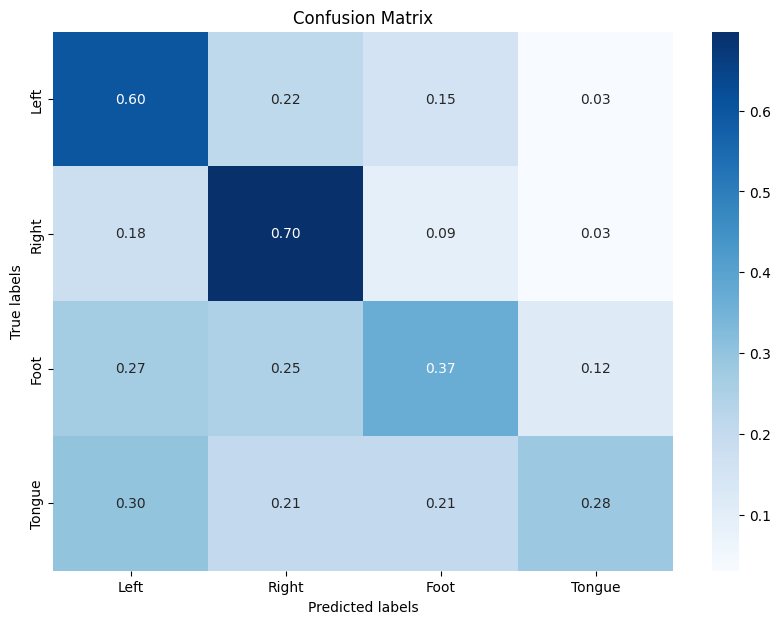

In [25]:
classes_list = ['Left', 'Right', 'Foot', 'Tongue']
eval_model = EvalModel(trained_eegnet_model)
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)
